In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier


In [8]:
df = pd.read_csv(r"D:\Loan deafult prediction project\Copy of loan.csv")


In [9]:
# Step 1: Preprocess the dataset
# -------------------------------
# Example target: 'TARGET' (1 = default, 0 = repaid)
df = df.dropna()  # Drop missing rows (or handle accordingly)


In [11]:
print(df.columns)


Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')


In [12]:
X = df.drop("Loan_Status", axis=1)
y = df["Loan_Status"]


In [13]:
import difflib
print(difflib.get_close_matches("TARGET", df.columns, n=5))


[]


In [15]:
print(df.columns.tolist())


['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']


In [16]:
from sklearn.preprocessing import LabelEncoder

# Encode all object columns
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Replace "TARGET" with actual column name
X = df.drop("Loan_Status", axis=1)
y = df["Loan_Status"]


In [17]:
print(df.head())


   Loan_ID  Gender  Married  Dependents  Education  Self_Employed  \
1        0       1        1           1          0              0   
2        1       1        1           0          0              1   
3        2       1        1           0          1              0   
4        3       1        0           0          0              0   
5        4       1        1           2          0              1   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   
5             5417             4196.0       267.0             360.0   

   Credit_History  Property_Area  Loan_Status  
1             1.0              0            0  
2             1.0              2            1  
3             

In [19]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
# Step 2: Train Model
# -------------------------------
model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
model.fit(X_train, y_train)

# Predict probabilities
y_probs = model.predict_proba(X_test)[:, 1]


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:51:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [21]:
# Step 3: Business Cost Optimization
# -------------------------------
# Define cost matrix
cost_fp = 100  # Cost for giving a loan to someone who defaults
cost_fn = 20   # Cost for rejecting a good customer

# Try various thresholds and calculate total cost
thresholds = np.arange(0.1, 0.9, 0.01)
costs = []

for thresh in thresholds:
    preds = (y_probs >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    total_cost = fp * cost_fp + fn * cost_fn
    costs.append(total_cost)

In [22]:
# Find optimal threshold
optimal_idx = np.argmin(costs)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.2f} with Total Cost: ${costs[optimal_idx]}")


Optimal Threshold: 0.51 with Total Cost: $1100


In [23]:
# Final evaluation
final_preds = (y_probs >= optimal_threshold).astype(int)
print("\nClassification Report:\n")
print(classification_report(y_test, final_preds))



Classification Report:

              precision    recall  f1-score   support

           0       0.78      0.64      0.71        28
           1       0.86      0.93      0.89        68

    accuracy                           0.84        96
   macro avg       0.82      0.78      0.80        96
weighted avg       0.84      0.84      0.84        96



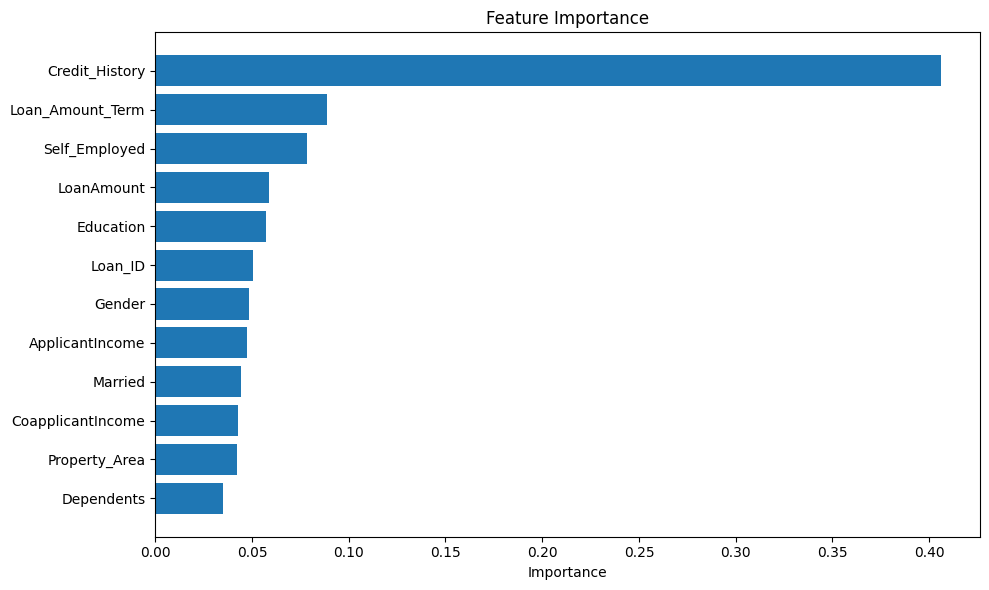

In [24]:
# Step 4: Feature Importance
# -------------------------------
importances = model.feature_importances_
features = X.columns
sorted_idx = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.barh(range(len(features)), importances[sorted_idx], align='center')
plt.yticks(range(len(features)), features[sorted_idx])
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [25]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc


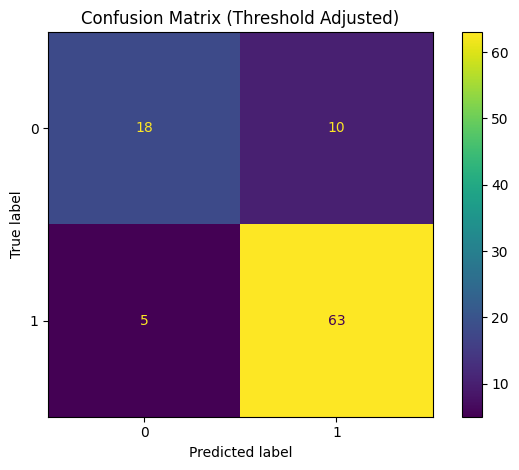

In [26]:
# ---- Confusion Matrix ----
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, final_preds)
plt.title("Confusion Matrix (Threshold Adjusted)")
plt.tight_layout()
plt.show()

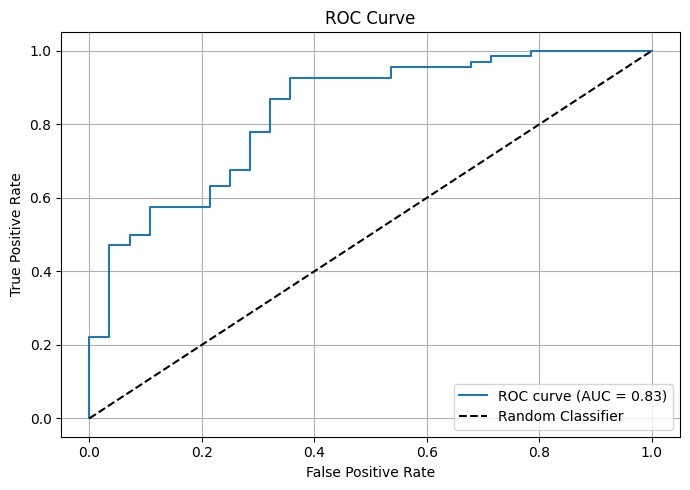

In [27]:
# ---- ROC Curve ----
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

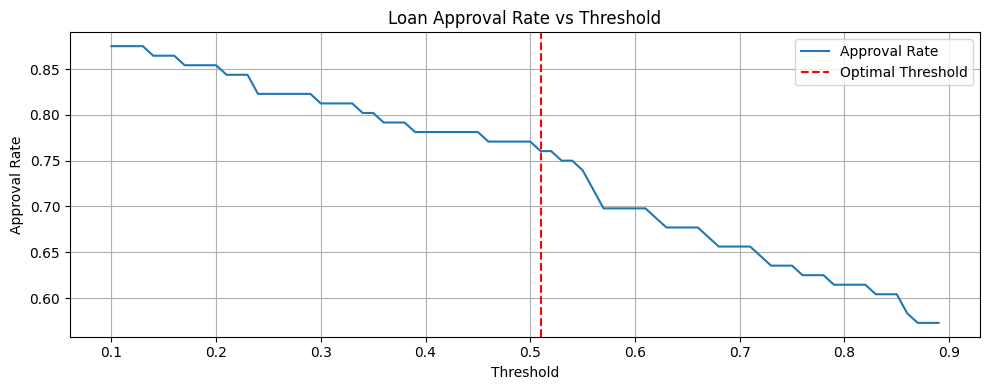

In [28]:
# ---- Approval Rate vs Threshold ----
approval_rates = [(y_probs >= t).mean() for t in thresholds]
plt.figure(figsize=(10, 4))
plt.plot(thresholds, approval_rates, label='Approval Rate')
plt.axvline(optimal_threshold, color='r', linestyle='--', label='Optimal Threshold')
plt.title("Loan Approval Rate vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Approval Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

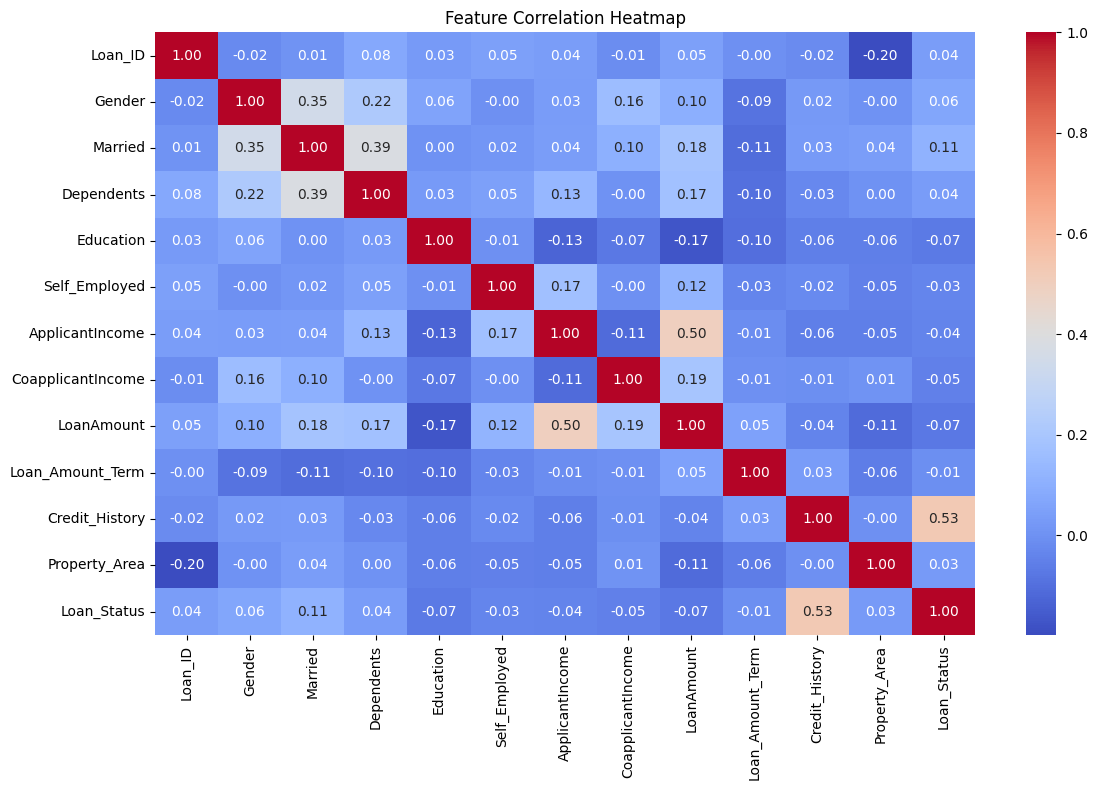

In [29]:
# ---- Correlation Heatmap ----
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()